# Formation RNAseq CEA - juin 2023

Session IFB : 5 CPU + 21 GB de RAM

# Part 8: Exploratory analysis I (before normalisation)

   

- 0. 1 - About session for IFB core cluster
- 0. 2 - Parameters to be set or modified by the user
- 1 - Some checks as a precaution
- 2 - Gene level quantification using ``featureCounts``
- 3 - Monitoring disk usage

---

## 0.1 - Setting up this R session on IFB core cluster

<em>loaded JupyterLab</em> : Version 3.2.1

Just as in a bash notebook, we can have information about the number of threads available for this session: 

In [4]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/jupyter/ {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,NODELIST -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Tue May 30 14:59:39 CEST 2023 ==="                        
[2] "          33586366      fast  jupyter scaburet  R    4:41:24      1 cpu-node-8"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                        
[4] "       JobID  AllocCPUS        NodeList "                                      
[5] "------------ ---------- --------------- "                                      
[6] "33586366              5      cpu-node-8 "                                      


Next we load into this R session the various tools that we will use:

In [122]:
## Code cell 2 ##

#library("pheatmap")
library("RColorBrewer")
library("ggplot2")
library("stringr")
library("matrixStats")
library(DESeq2)

#library("affy")
#library("ggfortify")


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply

and we can verify that all is ok before starting the analysis.

In [5]:
## Code cell 3 ##   

sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] readr_2.1.0        ggplot2_3.3.5      RColorBrewer_1.1-2

loaded via a namespace (and not attached):
 [1] pillar_1.8.1     compiler_4.0.3   base64enc_0.1-3  tools_4.0.3     
 [5] digest_0.6.28    uuid_1.0-3       jsonlite_1.7.2   evaluate_0.14   
 [9] lifecycle_1.0.1  tibble_3.1.8   

---

## 0.2 - Parameters to be set or modified by the user


- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

In [26]:
## Code cell 3 ##


gohome <- "/shared/projects/2312_rnaseq_cea/"
gohome

# In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened
getwd()

setwd("/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet") # temporaire pour mettre le jupynb en place
myfolder <- getwd()

myfolder


[1] "/shared/projects/2312_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet"

- With a `/` at the end, define the path to the folder where the results of this initial exploratory analysis will be stored:

In [34]:
## Code cell 4 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste(myfolder,"/Results/pca1/", sep = ""), recursive = TRUE)

# storing the path to this output folder in a variable
pca1folder <- paste(myfolder,"/Results/pca1/", sep = "")
pca1folder

# listing the content of the folder
print(system(paste("ls -hlt", pca1folder), intern = TRUE) )

Warning message in dir.create(paste(myfolder, "/Results/pca1/", sep = ""), recursive = TRUE):
“'/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/pca1' already exists”


[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/pca1/"

[1] "total 0"


## 1 - Loading input data and metadata

We now need two files:   
- the read counts produced by featureCounts (as in the Pipe_6 notebook), on all 11 samples   
- a metadata file, providing information about the samples, in particular the conditions of the experiment. 

We copy both these file in our personal folder:

In [35]:
file.copy("/shared/projects/2312_rnaseq_cea/allData/Results/featurecounts/allSample_paired-unstranded.counts", myfolder)
file.copy("/shared/projects/2312_rnaseq_cea/allData/Data/sampleData-GSE158661.tsv", myfolder)

[1] TRUE

[1] TRUE

You should have obtained 2 TRUE output, and the files should appear in your folder in the left column.

### 1.1 - Loading metadata   

We read the tabulated table and we store the data in a dataframe named `samples`.   
The file has column names, so we set header=TRUE, and the separator is a tab (sep = "\t").

In [55]:
samples <- read.table("sampleData-GSE158661.tsv", sep="\t", header=TRUE, stringsAsFactors=F)

In [56]:
class(samples)

[1] "data.frame"

In [57]:
head(samples)

,SampleID,SampleName,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR12730403,dHet_B-ALL_686_rep1,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
2,SRR12730404,dHet_B-ALL_686_rep2,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
3,SRR12730405,dHet_B-ALL_713_rep1,Ebf1+/- Pax5+/-,GSM4805162,GSM4805162,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
4,SRR12730406,dHet_B-ALL_713_rep2,Ebf1+/- Pax5+/-,GSM4805163,GSM4805163,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
5,SRR12730407,dHet_B-ALL_760_rep1,Ebf1+/- Pax5+/-,GSM4805164,GSM4805164,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
6,SRR12730408,dHet_B-ALL_760_rep2,Ebf1+/- Pax5+/-,GSM4805165,GSM4805165,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node


### 1.2 - Loading counts data   

We read the tabulated table and we store the data in a dataframe named `counts`.   
In addition to specufying the separator and the columns names, we also indicate that lines beginning with "#" are comments and should be ignored.

In [58]:
#counts <- readr::read_tsv("allSample_paired-unstranded.counts",col_names = TRUE, comment="#")

In [59]:
counts <- read.table("allSample_paired-unstranded.counts", sep="\t", header=TRUE, comment="#")

In [60]:
class(counts)

[1] "data.frame"

In [61]:
head(counts)

,Geneid,Chr,Start,End,Strand,Length,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730403_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730404_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730405_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730406_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730407_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730408_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730409_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730410_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730411_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730412_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730413_Aligned.sortedByNames.bam
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSMUSG00000102693.2,chr1,3143476,3144545,+,1070,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000064842.3,chr1,3172239,3172348,+,110,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000051951.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;3491925;3740775,3277540;3277540;3285855;3286567;3287191;3492124;3741721,-;-;-;-;-;-;-,6094,0,0,0,0,0,0,0,1,0,0,0
4,ENSMUSG00000102851.2,chr1,3322980,3323459,+,480,0,0,0,0,0,0,0,0,0,0,1
5,ENSMUSG00000103377.2,chr1,3435954,3438772,-,2819,0,0,0,0,0,0,0,0,0,0,0
6,ENSMUSG00000104017.2,chr1,3445779,3448011,-,2233,0,0,0,0,0,0,0,0,0,0,0


### 1.3 - Data preprocessing   

The countdata contains some columns which are irrelevant to our analysis and will be removed.    
These include the chromosome numbers, start and end positions, gene length and gene biotype. We don't need this information to perform the exploratory and differential expression analysis, hence we drop these with the following code.


In [97]:
countdata <- counts[, c(5:17)]
countdata <- countdata[, -c(2)]
countdata <- countdata[, -c(1)]
rownames(countdata) <- counts[,1] 

In [98]:
head(countdata)
#head(genes)

,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730403_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730404_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730405_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730406_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730407_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730408_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730409_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730410_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730411_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730412_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730413_Aligned.sortedByNames.bam
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,0,0,0,0,0,0,0,1,0,0,0
ENSMUSG00000102851.2,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000103377.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017.2,0,0,0,0,0,0,0,0,0,0,0


In [99]:
dim(countdata)

[1] 57010    11

The names of the columns are not very easy to read, and most of all, they don't correspond to the nams present in the first column of the metadata, therefore, we cannot have any correspondance between the two information. So we modify the names of the columns in `countdata`, in order to remove the first 64 characters, and then the 

In [100]:

# We remove the common prefix
colnames(countdata) <- gsub("X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.","",colnames(countdata))

# We remove the common suffix
colnames(countdata) <- gsub("_Aligned.sortedByNames.bam","",colnames(countdata))

#colnames(countdata) <- stringr::str_sub(colnames(countdata),65) 
# j'avais trouvé ça, mais je préfère ne pas enlever un nombre de caractères : si on le fait plusieurs fois c'est la cata

In [101]:
head(countdata)

,SRR12730403_Aligned.sortedByNames.bam,SRR12730404_Aligned.sortedByNames.bam,SRR12730405_Aligned.sortedByNames.bam,SRR12730406_Aligned.sortedByNames.bam,SRR12730407_Aligned.sortedByNames.bam,SRR12730408_Aligned.sortedByNames.bam,SRR12730409_Aligned.sortedByNames.bam,SRR12730410_Aligned.sortedByNames.bam,SRR12730411_Aligned.sortedByNames.bam,SRR12730412_Aligned.sortedByNames.bam,SRR12730413_Aligned.sortedByNames.bam
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,0,0,0,0,0,0,0,1,0,0,0
ENSMUSG00000102851.2,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000103377.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017.2,0,0,0,0,0,0,0,0,0,0,0


In [102]:
colnames(countdata) <- gsub("_Aligned.sortedByNames.bam","",colnames(countdata))

In [103]:
head(countdata)

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,0,0,0,0,0,0,0,1,0,0,0
ENSMUSG00000102851.2,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000103377.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017.2,0,0,0,0,0,0,0,0,0,0,0


### 1.4 - Filtering out genes with a low expression

For many analysis methods it is advisable to filter out as many genes as possible before the analysis to decrease the impact of multiple testing correction on false discovery rates.   
This is normally done by filtering out genes with low numbers of reads and thus likely to be uninformative from a biological point of view.
(With DESeq2, the tool that we will use later for differential analysis, this is not necessary as it applies independent filtering during the analysis.) 
In addition, some filtering for genes that are very lowly expressed does reduce the size of the data matrix, meaning that less memory is required and processing steps are carried out faster.

Here, we will keep all genes where the total number of reads across all 11 samples is greater than 10.   
We count how many genes we have at first (= how many rows): 

In [108]:
# check dimension of count matrix
dim(countdata)

# 57010 11

[1] 57010    11

For each gene, we compute the total count of read i all samples, and compare to our threshold. We count the number of genes passing the test.

In [109]:
 
# keeping outcome in vector of 'logicals' (ie TRUE or FALSE, or NA)
keep <- rowSums(countdata) > 10

# summary of test outcome: number of genes in each class:
table(keep, useNA="always") 

keep
FALSE  TRUE  <NA> 
34083 22927     0 

We extract those genes, and store them in a new dataframe

In [110]:

# subset genes where test was TRUE
countdata2 <- countdata[keep,]
# check dimension of new count matrix
dim(countdata2)

# 22927 11

[1] 22927    11

## 2 - Quality assessment

Before moving on to doing the actual differential expression analysis, it is important to assess the quality of our data.

### 2.1 - Data transformations and visualization

Differential expression calculations with DESeq2 uses raw read counts as input, but for visualization purposes we use transformed counts.
Raw counts

Why not raw counts? Two issues:

    - Raw counts range is very large: some higly expressed genes can have millions of reads
    - Variance increases with mean gene expression, and this has impact on assessing the relationships.
    
Let's display the range of expression of our raw read counts:

In [111]:

summary(countdata2)

  SRR12730403      SRR12730404      SRR12730405      SRR12730406    
 Min.   :     0   Min.   :     0   Min.   :     0   Min.   :     0  
 1st Qu.:     5   1st Qu.:     4   1st Qu.:     4   1st Qu.:     4  
 Median :    70   Median :    60   Median :    50   Median :    56  
 Mean   :  1884   Mean   :  1471   Mean   :  1338   Mean   :  1393  
 3rd Qu.:  1435   3rd Qu.:  1174   3rd Qu.:  1022   3rd Qu.:  1095  
 Max.   :380993   Max.   :294250   Max.   :460910   Max.   :465330  
  SRR12730407      SRR12730408      SRR12730409      SRR12730410      
 Min.   :     0   Min.   :     0   Min.   :     0   Min.   :     0.0  
 1st Qu.:     3   1st Qu.:     3   1st Qu.:     3   1st Qu.:     3.0  
 Median :    51   Median :    55   Median :    43   Median :    38.0  
 Mean   :  1549   Mean   :  1411   Mean   :  1152   Mean   :  1218.1  
 3rd Qu.:  1222   3rd Qu.:  1180   3rd Qu.:   918   3rd Qu.:   901.5  
 Max.   :254944   Max.   :212782   Max.   :169735   Max.   :187547.0  
  SRR12730411       

Few outliers affect distribution visualization

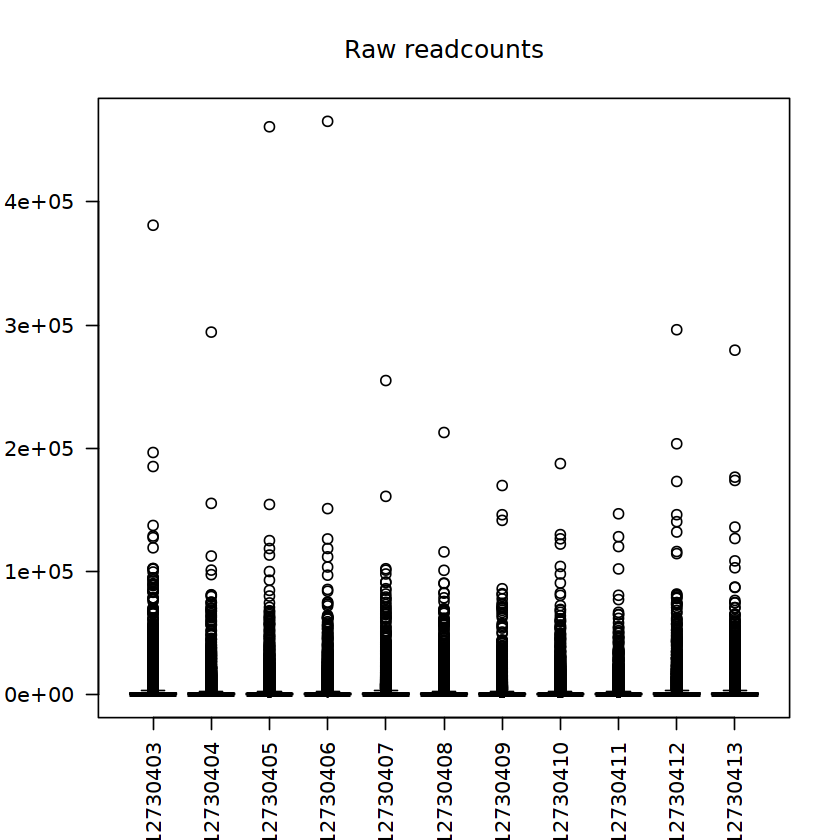

In [115]:
boxplot(countdata2, main='Raw readcounts', las=2)

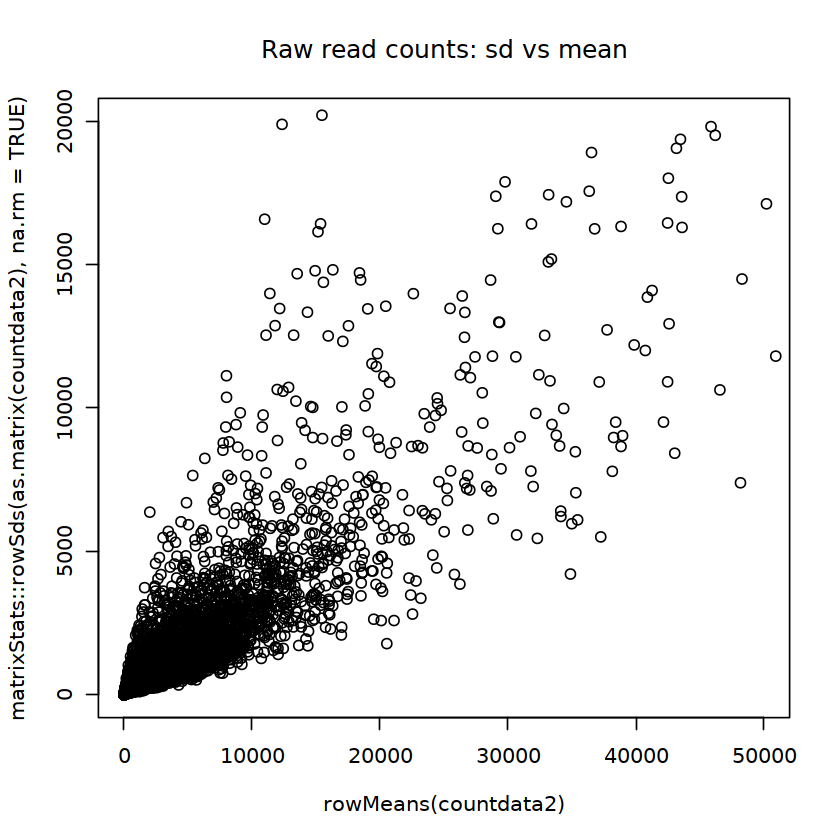

In [131]:
# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(countdata2), matrixStats::rowSds(as.matrix(countdata2), na.rm=TRUE), 
     main='Raw read counts: sd vs mean', 
     xlim=c(0,50000),
     ylim=c(0,20000))